<a href="https://colab.research.google.com/github/williamedwardhahn/ComplexSystems/blob/main/Complex_Systems_Lab_Dictionary_Learning_X_Cubed_X3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade scikit-image progressbar2

     |████████████████████████████████| 12.4MB 6.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


In [ ]:
!pip install tflearn #for dataset

     |████████████████████████████████| 112kB 8.1MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp36-none-any.whl size=127301 sha256=cf3067faa2a9079487e6d0f0ca757c1b89b73c6622ca0d7787380fd2c76c4ad3
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [ ]:
from skimage.util import view_as_blocks, view_as_windows, montage
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import time
import os
import copy
import torch
from torch import tensor 
from torch.autograd import Variable
from torch import randn, matmul
import matplotlib.pyplot as plt
# from scipy.misc import imresize, bytescale
from progressbar import progressbar
from google.colab import files
import matplotlib.pyplot as plt
import time
from torchvision.models import *

In [ ]:
def plot(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x)
    ax.axis('off')
    fig.set_size_inches(18, 10)
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(resize_pics=(227, 227), one_hot=True)

Instructions for updating:
non-resource variables are not supported in the long term


100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [ ]:
X.shape, Y.shape

((1360, 227, 227, 3), (1360, 17))

In [ ]:
r = np.random.permutation(1000)
X = X[r,:,:,:]
Y = Y[r,:]

In [ ]:
X_train = X[0:int(0.8*X.shape[0])]
X_val = X[int(0.8*X.shape[0]):X.shape[0]] 

In [ ]:
Y_train = Y[0:int(0.8*Y.shape[0])]
Y_val = Y[int(0.8*Y.shape[0]):Y.shape[0]] 

In [ ]:
Data = {'train':X_train,'val':X_val}
Labels = {'train':Y_train,'val':Y_val}

In [ ]:
X1=X[0:256]

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: torch.utils.data.TensorDataset(torch.tensor(Data[x], dtype=torch.float).transpose(3,1),torch.tensor(Labels[x], dtype=torch.float)) for x in ['train', 'val']}
dataloaders    = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes  = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [ ]:
def NC(a): #normalize columns
  return torch.mm(a, torch.diag(1./(torch.sqrt(torch.sum(a**2, 0))+1e-6)))

In [ ]:
def r_svd_gpu(M, k=100):
    B = torch.tensor(M).cuda(0)
    m, n = B.size()
    transpose = False
    if m < n:
        transpose = True
        B = B.transpose(0, 1).cuda(0)
        m, n = B.size()
    rand_matrix = torch.rand((n,k), dtype=torch.double).cuda(0)  # short side by k
    Q, _ = torch.qr(B @ rand_matrix.float())                              # long side by k
    Q.cuda(0)
    smaller_matrix = (Q.transpose(0, 1) @ B).cuda(0)             # k by short side
    U_hat, s, V = torch.svd(smaller_matrix,False)
    U_hat.cuda(0)
    U = (Q @ U_hat)
    
    if transpose:
        return V.transpose(0, 1), s, U.transpose(0, 1)
    else:
        return U.cpu(), s.cpu(), V.cpu()

In [ ]:
def toImg(arr):
  return ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')

In [ ]:
def whiten(X):
    
    U,S,V = r_svd_gpu(torch.mm(X, torch.t(X)))
    epsilon = 0#1e-5
    ZCAMatrix = torch.mm(U, torch.mm(torch.diag(1.0/torch.sqrt(S + epsilon)),torch.t(U)))

    return torch.mm(ZCAMatrix, X)

In [ ]:
def get_batch(X, patchshape, batch_size=256):
  
  ix = randint(0,X.shape[1]-patchshape[0])
  iy = randint(0,X.shape[2]-patchshape[1])
  iz = randint(0,X.shape[3]-patchshape[2]) if patchshape[2] != X.shape[3] else 0
  
  iax = ix + patchshape[0]
  iay = iy + patchshape[1]
  iaz = iz + patchshape[2]

  B = X[randint(0,X.shape[0], size=batch_size),ix:iax,iy:iay,iz:iaz].contiguous().view(batch_size, patchshape[0]*patchshape[1]*patchshape[2])

  B = B.t()
  
  B = whiten((B - torch.mean(B, 0)))
  
  return B

In [ ]:
def bold(a):
    
    a = a.cpu().numpy()
    
    for i in range(a.shape[1]):
    
        a[:,i] = np.convolve(a[:,i],[1,1,1], 'same')
    
    return torch.tensor(a).cuda(0)

In [ ]:
# def conv1(w,f): #GPU conv with padding

#     n = torch.nn.functional.conv1d(w,f)
#     n = pad(n, (1, 1)) 

#     return n

In [ ]:
# def bold(a):
    
#     f = torch.ones((1,1,3)).cuda()

#     for i in range(a.shape[1]):
    
#         a[:,i] = conv1(a[:,i][None,None,:],f)
    
#     return a

In [ ]:
def X3(X, filter_size, filter_depth, num_filters, iters=300):
  
  W = Variable(randn(filter_size*filter_size*filter_depth,num_filters)).cuda(0)
  
  for i in progressbar(range(iters)):
    
    lX = get_batch(X, (filter_size, filter_size, filter_depth)).cuda(0)
    
    W = NC(W)
    
    a = torch.matmul(W.t(), lX)
    
    a = NC(a)
    
    a = a.pow(3)
    
    a = bold(a)
    
    W += matmul((lX - matmul(W,a)),a.t())
    
  
  return W.transpose(1,0).view(num_filters, filter_size, filter_size, filter_depth)

In [ ]:
Xp = torch.tensor(X1, dtype=torch.float)

In [ ]:
Xp.shape

torch.Size([256, 227, 227, 3])

In [ ]:
# Xp

In [ ]:
W = X3(Xp,11,3,256)

N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


In [ ]:
W.shape

torch.Size([256, 11, 11, 3])

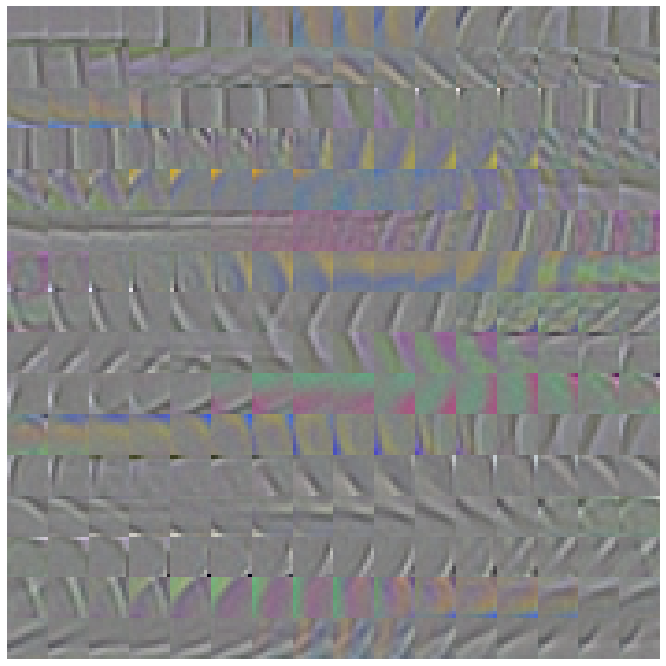

In [ ]:
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(montage(toImg(W.cpu().numpy()), multichannel=True))

N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
100% (2000 of 2000) |####################| Elapsed Time: 0:00:53 Time:  0:00:53


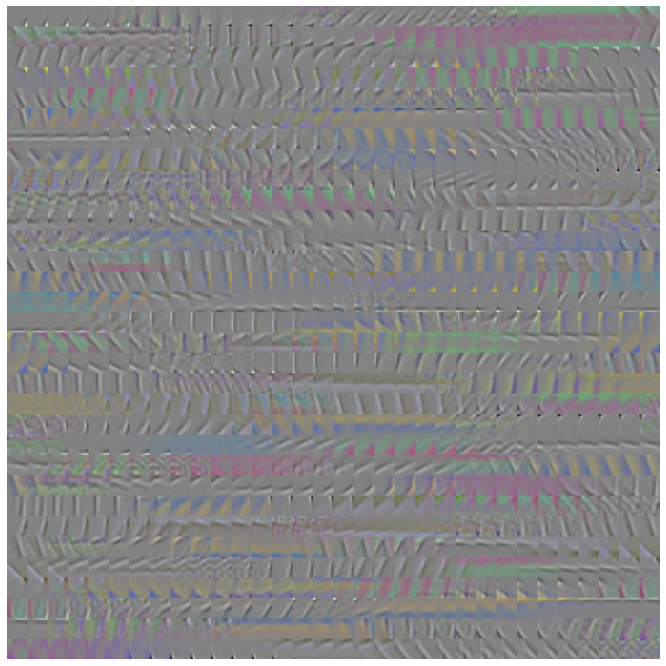

In [ ]:
W = X3(Xp,11,3,1024, iters=2000)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(montage(toImg(W.cpu().numpy()), multichannel=True))

N/A% (0 of 5000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
100% (5000 of 5000) |####################| Elapsed Time: 0:15:37 Time:  0:15:37


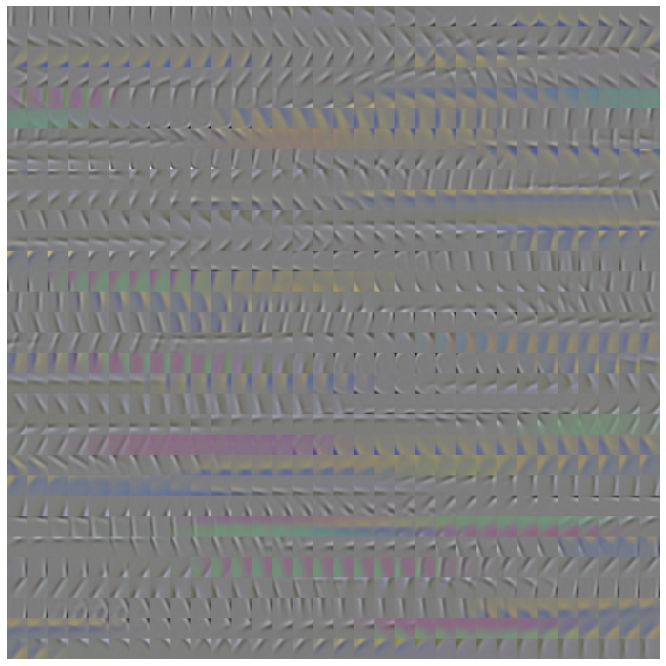

In [ ]:
W = X3(Xp,32,3,1024, iters=5000)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(montage(toImg(W.cpu().numpy()), multichannel=True))

N/A% (0 of 10000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
100% (10000 of 10000) |##################| Elapsed Time: 0:40:21 Time:  0:40:21


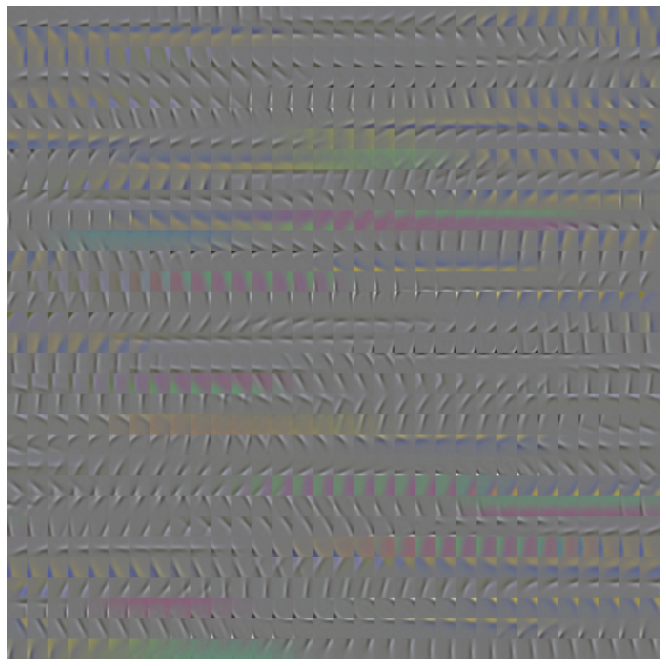

In [ ]:
W = X3(Xp,32,3,1024, iters=10000)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(montage(toImg(W.cpu().numpy()), multichannel=True))